In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import tensorflow as tf

# Configure TensorFlow GPU settings
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

def positional_encoding(length: int, depth: int):
    """
    Generates a positional encoding for a given length and depth.

    Args:
        length (int): The length of the input sequence.
        depth (int): The depth that represents the dimensionality of the encoding.

    Returns:
        tf.Tensor: The positional encoding of shape (length, depth).
    """
    depth = depth // 2  # Halve the depth

    # Create position and depth arrays
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    # Compute angle rates
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    # Compute sine and cosine embeddings
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

Positional encoding shape: (2048, 512)


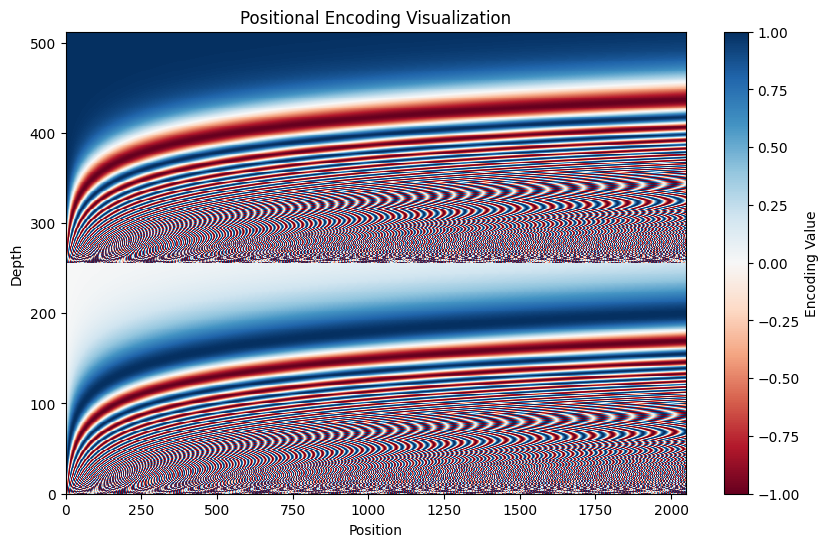

In [3]:
import matplotlib.pyplot as plt

# Generate positional encoding
pos_encoding = positional_encoding(length=2048, depth=512)

# Print the shape of the positional encoding
print(f"Positional encoding shape: {pos_encoding.shape}")

# Visualize the positional encoding
plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')  # Transpose to flip axes
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar(label='Encoding Value')  # Add label to the colorbar
plt.title('Positional Encoding Visualization')
plt.show()

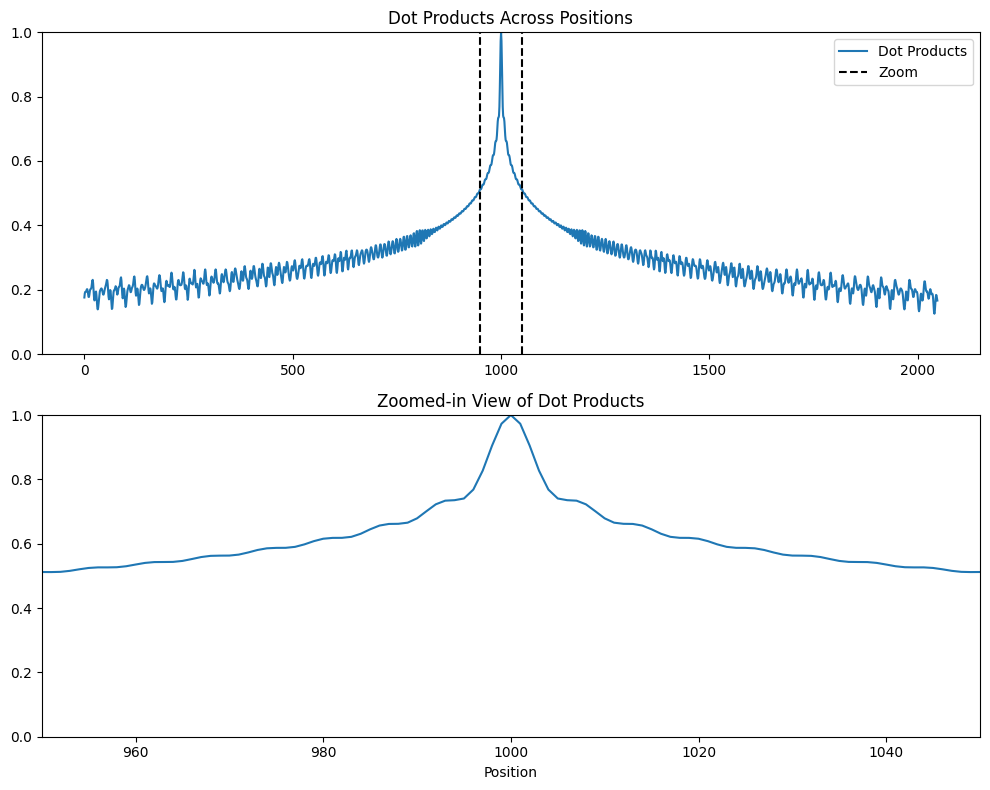

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Normalize positional encoding
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)

# Choose a specific position for analysis
p = pos_encoding[1000]

# Compute dot products between the chosen position and the entire encoding
dots = tf.einsum('pd,d->p', pos_encoding, p).numpy()

# Create a subplot to visualize the data
plt.figure(figsize=(10, 8))

# Subplot 1: Entire range of dot products
plt.subplot(2, 1, 1)
plt.plot(dots, label='Dot Products')
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1], 
         color='k', label='Zoom', linestyle='--')  # Zoom indicator
plt.legend()
plt.title('Dot Products Across Positions')

# Subplot 2: Zoomed-in view
plt.subplot(2, 1, 2)
plt.plot(range(len(dots)), dots)
plt.xlim([950, 1050])  # Focus on the range [950, 1050]
plt.ylim([0, 1])
plt.xlabel('Position')
plt.title('Zoomed-in View of Dot Products')

# Show the plots
plt.tight_layout()
plt.show()

In [5]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    A positional embedding layer combines the input embedding with a positional encoding that helps the Transformer
    to understand the relative position of the input tokens. This layer takes the input of tokens and converts them
    into a sequence of embedding vectors. Then, it adds the positional encoding to the embeddings.

    Methods:
        compute_mask: Computes the mask to be applied to the embeddings.
        call: Performs the forward pass of the layer.
    """
    def __init__(self, vocab_size: int, d_model: int, embedding: tf.keras.layers.Embedding = None):
        """
        Constructor of the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary. I.e. the number of unique tokens in the input sequence.
            d_model (int): The dimensionality of the embedding vector.
            embedding (tf.keras.layers.Embedding): The custom embedding layer. If None, a default embedding layer will be created.
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = (
            tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
            if embedding is None
            else embedding
        )
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        """
        Computes the mask to be applied to the embeddings.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of embedding vectors with added positional information. The shape is
            (batch_size, seq_length, d_model).
        """
        x = self.embedding(x)
        length = tf.shape(x)[1]
        # This factor sets the relative scale of the embedding and positional encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [6]:
vocab_size = 1000
d_model = 512

embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_input = np.random.randint(0, vocab_size, size=(1, 100))

output = embedding_layer(random_input)
print("random_input shape", random_input.shape)
print("PositionalEmbedding output", output.shape)

random_input shape (1, 100)
PositionalEmbedding output (1, 100, 512)


In [7]:
import numpy as np
import tensorflow as tf

class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """
        Constructor of the BaseAttention layer.

        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e.g.
            num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [8]:
class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.

    Methods:
    --------
    call: Performs the forward pass of the layer.

    Attributes:
    -----------
    mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
    layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    add (tf.keras.layers.Add): The Add layer.
    """

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.

        Args:
        -----
        x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
        context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).

        Returns:
        --------
        tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [9]:
encoder_vocab_size = 1000
decoder_vocab_size = 1100
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)
decoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))
random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

# Clip the input values to be within the valid range
random_decoder_input = np.clip(random_decoder_input, 0, vocab_size - 1)

# Pass the clipped input to the embedding layer
decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)

cross_attention_layer = CrossAttention(num_heads=2, key_dim=512)
cross_attention_output = cross_attention_layer(decoder_embeddings, encoder_embeddings)

print("cross_attention_output shape", cross_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
decoder_embeddings shape (1, 110, 512)
cross_attention_output shape (1, 110, 512)


In [10]:
class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [11]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

cross_attention_layer = GlobalSelfAttention(num_heads=2, key_dim=512)
cross_attention_output = cross_attention_layer(encoder_embeddings)

print("global_self_attention_output shape", cross_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
global_self_attention_output shape (1, 100, 512)


In [12]:
class CausalSelfAttention(BaseAttention):
    """
    Call self-attention on the input sequence, ensuring that each position in the 
    output depends only on previous positions (i.e. a causal model).

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the causal self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [13]:
decoder_vocab_size = 1100
d_model = 512

decoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

# Clip the input values to be within the valid range
random_decoder_input = np.clip(random_decoder_input, 0, vocab_size - 1)

# Pass the clipped input to the embedding layer
decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("decoder_embeddings shape", decoder_embeddings.shape)

causal_self_attention_layer = CausalSelfAttention(num_heads=2, key_dim=512)
causal_self_attention_output = causal_self_attention_layer(decoder_embeddings)

print("causal_self_attention_output shape", causal_self_attention_output.shape)

out1 = causal_self_attention_layer(decoder_embedding_layer(random_decoder_input[:, :50]))  # Only the first 50 tokens before applying the embedding layer
out2 = causal_self_attention_layer(decoder_embedding_layer(random_decoder_input[:, :50]))  # Only the first 50 tokens after applying the embedding layer

diff = tf.reduce_max(tf.abs(out1 - out2)).numpy()

print("Difference between the two outputs:", diff)

decoder_embeddings shape (1, 110, 512)
causal_self_attention_output shape (1, 110, 512)
Difference between the two outputs: 0.0


In [14]:
class FeedForward(tf.keras.layers.Layer):
    """
    A class that implements the feed-forward layer.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        seq (tf.keras.Sequential): The sequential layer that contains the feed-forward layers. 
                                   It applies the two feed-forward layers and dropout.
        add (tf.keras.layers.Add): The Add layer.
        layer_norm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    """

    def __init__(self, d_model: int, dff: int, dropout_rate: float = 0.1):
        """
        Constructor of the FeedForward layer.

        Args:
            d_model (int): The dimensionality of the model.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the feed-forward operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [15]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

feed_forward_layer = FeedForward(d_model, dff=2048)
feed_forward_output = feed_forward_layer(encoder_embeddings)

print("feed_forward_output shape", feed_forward_output.shape)

encoder_embeddings shape (1, 100, 512)
feed_forward_output shape (1, 100, 512)


In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Encoder. Usually there are multiple layers stacked on top of each other.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        self_attention (GlobalSelfAttention): The global self-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the EncoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
            )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [17]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

encoder_layer = EncoderLayer(d_model, num_heads=2, dff=2048)

encoder_layer_output = encoder_layer(encoder_embeddings)

print("encoder_layer_output shape", encoder_layer_output.shape)

encoder_embeddings shape (1, 100, 512)
encoder_layer_output shape (1, 100, 512)


In [18]:
class Encoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Encoder. This layer is mostly used in the Transformer models 
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the encoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        enc_layers (list): The list of encoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Encoder.

        Args:
            num_layers (int): The number of layers in the encoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.
        
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.pos_embedding(x)  
        # here x has shape `(batch_size, seq_len, d_model)`

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [19]:
encoder_vocab_size = 1000
d_model = 512

encoder = Encoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=encoder_vocab_size)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_output = encoder(random_encoder_input)

print("random_encoder_input shape", random_encoder_input.shape)
print("encoder_output shape", encoder_output.shape)

random_encoder_input shape (1, 100)
encoder_output shape (1, 100, 512)


In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Decoder. Usually there are multiple layers stacked on top of each other.
    
    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        causal_self_attention (CausalSelfAttention): The causal self-attention layer.
        cross_attention (CrossAttention): The cross-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the DecoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate. 
        """
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model). x is usually the output of the previous decoder layer.
            context (tf.Tensor): The context sequence of shape (batch_size, seq_length, d_model). Context is usually the output of the encoder.
        """
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [21]:
# Test DecoderLayer layer
decoder_vocab_size = 1000
d_model = 512
dff = 2048
num_heads = 8

decoder_layer = DecoderLayer(d_model, num_heads, dff)

random_decoderLayer_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

decoder_embeddings = encoder_embedding_layer(random_decoderLayer_input)

decoderLayer_output = decoder_layer(decoder_embeddings, encoder_output)

print("random_decoder_input shape", random_decoderLayer_input.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)
print("decoder_output shape", decoderLayer_output.shape)

random_decoder_input shape (1, 110)
decoder_embeddings shape (1, 110, 512)
decoder_output shape (1, 110, 512)


In [22]:
class Decoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Decoder. This layer is mostly used in the Transformer models
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the decoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        dec_layers (list): The list of decoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Decoder.

        Args:
            num_layers (int): The number of layers in the decoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, 
                num_heads=num_heads, 
                dff=dff, 
                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, target_seq_len).
            context (tf.Tensor): The context sequence of shape (batch_size, input_seq_len, d_model).
        """
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [23]:
# Test decoder layer
decoder_vocab_size = 1000
d_model = 512

decoder_layer = Decoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=decoder_vocab_size)

random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 100))

decoder_output = decoder_layer(random_decoder_input, encoder_output)

print("random_decoder_input shape", random_decoder_input.shape)
print("decoder_output shape", decoder_output.shape)

random_decoder_input shape (1, 100)
decoder_output shape (1, 100, 512)


In [24]:
def Transformer(
    input_vocab_size: int, 
    target_vocab_size: int, 
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6, 
    d_model: int=512, 
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64), 
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]
    
    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [25]:
encoder_input_size = 100
decoder_input_size = 110

encoder_vocab_size = 1000
decoder_vocab_size = 1000

model = Transformer(
    input_vocab_size=encoder_vocab_size,
    target_vocab_size=decoder_vocab_size,
    encoder_input_size=encoder_input_size,
    decoder_input_size=decoder_input_size,
    num_layers=2,
    d_model=512,
    num_heads=2,
    dff=512,
    dropout_rate=0.1)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Encoder) │ (None, 100, 512)  │  5,768,192 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Decoder) │ (None, 110, 512)  │  9,971,712 │ input_layer_8[0]… │
│                     │                   │            │ encoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 110, 1000) │    513,000 │ decoder_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,252,904 (62.00 MB)

 Trainable params: 16,252,904 (62.00 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
import os
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup

# URL to the directory containing the files to be downloaded
language = "en-hi"
url = f"https://data.statmt.org/opus-100-corpus/v1.0/supervised/{language}/"
save_directory = f"./Datasets/{language}"

# Create the save directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML response
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the anchor tags in the HTML
links = soup.find_all('a')

# Extract the href attribute from each anchor tag
file_links = [link['href'] for link in links if '.' in link['href']]

# Download each file
for file_link in tqdm(file_links):
    file_url = url + file_link
    save_path = os.path.join(save_directory, file_link)
    
    print(f"Downloading {file_url}")
    
    # Send a GET request for the file
    file_response = requests.get(file_url)
    if file_response.status_code == 404:
        print(f"Could not download {file_url}")
        continue
    
    # Save the file to the specified directory
    with open(save_path, 'wb') as file:
        file.write(file_response.content)
    
    print(f"Saved {file_link}")

print("All files have been downloaded.")

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:06,  1.14s/it]

Could not download https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-hi//opus-100-corpus/v1.0/supervised/


 29%|██▊       | 2/7 [00:02<00:06,  1.24s/it]

Saved opus.en-hi-dev.en


 43%|████▎     | 3/7 [00:04<00:05,  1.45s/it]

Saved opus.en-hi-dev.hi


 57%|█████▋    | 4/7 [00:05<00:04,  1.35s/it]

Saved opus.en-hi-test.en


 71%|███████▏  | 5/7 [00:07<00:03,  1.63s/it]

Saved opus.en-hi-test.hi


 86%|████████▌ | 6/7 [00:42<00:13, 13.00s/it]

Saved opus.en-hi-train.en


100%|██████████| 7/7 [02:13<00:00, 19.05s/it]

Saved opus.en-hi-train.hi
All files have been downloaded.


In [27]:
en_training_data_path = "Datasets/en-hi/opus.en-hi-train.en"
en_validation_data_path = "Datasets/en-hi/opus.en-hi-dev.en"
hi_training_data_path = "Datasets/en-hi/opus.en-hi-train.hi"
hi_validation_data_path = "Datasets/en-hi/opus.en-hi-dev.hi"

def read_filhi(path):
    with open(path, "r", encoding="utf-8") as f:
        en_train_dataset = f.read().split("\n")[:-1]
    return en_train_dataset

en_training_data = read_filhi(en_training_data_path)
en_validation_data = read_filhi(en_validation_data_path)
hi_training_data = read_filhi(hi_training_data_path)
hi_validation_data = read_filhi(hi_validation_data_path)

max_lenght = 500
train_dataset = [[hi_sentence, en_sentence] for hi_sentence, en_sentence in zip(hi_training_data, en_training_data) if len(hi_sentence) <= max_lenght and len(en_sentence) <= max_lenght]
val_dataset = [[hi_sentence, en_sentence] for hi_sentence, en_sentence in zip(hi_validation_data, en_validation_data) if len(hi_sentence) <= max_lenght and len(en_sentence) <= max_lenght]
hi_training_data, en_training_data = zip(*train_dataset)
hi_validation_data, en_validation_data = zip(*val_dataset)

print(len(hi_training_data))
print(len(hi_validation_data))
print(hi_training_data[:3])
print(en_training_data[:3])

531604
1986
('अन्य, निज़ी उपयोग', 'ऊबड़ .', 'जीवनसाथी')
('Other, Private Use', '[SCREAMING]', 'Spouse')


In [28]:
import os
import json
import typing
from tqdm import tqdm

class CustomTokenizer:
    """ Custom Tokenizer class to tokenize and detokenize text data into sequences of integers

    Args:
        split (str, optional): Split token to use when tokenizing text. Defaults to " ".
        char_level (bool, optional): Whether to tokenize at character level. Defaults to False.
        lower (bool, optional): Whether to convert text to lowercase. Defaults to True.
        start_token (str, optional): Start token to use when tokenizing text. Defaults to "<start>".
        end_token (str, optional): End token to use when tokenizing text. Defaults to "<eos>".
        filters (list, optional): List of characters to filter out. Defaults to 
            ['!', "'", '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', 
            '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\t', '\n'].
        filter_nums (bool, optional): Whether to filter out numbers. Defaults to True.
        start (int, optional): Index to start tokenizing from. Defaults to 1.
    """
    def __init__(
            self, 
            split: str=" ", 
            char_level: bool=False,
            lower: bool=True, 
            start_token: str="<start>", 
            end_token: str="<eos>",
            filters: list = ['!', "'", '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\t', '\n'],
            filter_nums: bool = True,
            start: int=1,
        ) -> None:
        self.split = split
        self.char_level = char_level
        self.lower = lower
        self.index_word = {}
        self.word_index = {}
        self.max_length = 0
        self.start_token = start_token
        self.end_token = end_token
        self.filters = filters
        self.filter_nums = filter_nums
        self.start = start

    @property
    def start_token_index(self):
        return self.word_index[self.start_token]
    
    @property
    def end_token_index(self):
        return self.word_index[self.end_token]

    def sort(self):
        """ Sorts the word_index and index_word dictionaries"""
        self.index_word = dict(enumerate(dict(sorted(self.word_index.items())), start=self.start))
        self.word_index = {v: k for k, v in self.index_word.items()}

    def split_line(self, line: str):
        """ Splits a line of text into tokens

        Args:
            line (str): Line of text to split

        Returns:
            list: List of string tokens
        """
        line = line.lower() if self.lower else line

        if self.char_level:
            return [char for char in line]

        # split line with split token and check for filters
        line_tokens = line.split(self.split)

        new_tokens = []
        for index, token in enumerate(line_tokens):
            filtered_tokens = ['']
            for c_index, char in enumerate(token):
                if char in self.filters or (self.filter_nums and char.isdigit()):
                    filtered_tokens += [char, ''] if c_index != len(token) -1 else [char]
                else:
                    filtered_tokens[-1] += char

            new_tokens += filtered_tokens
            if index != len(line_tokens) -1:
                new_tokens += [self.split]

        new_tokens = [token for token in new_tokens if token != '']

        return new_tokens

    def fit_on_texts(self, lines: typing.List[str]):
        """ Fits the tokenizer on a list of lines of text
        This function will update the word_index and index_word dictionaries and set the max_length attribute

        Args:
            lines (typing.List[str]): List of lines of text to fit the tokenizer on
        """
        self.word_index = {key: value for value, key in enumerate([self.start_token, self.end_token, self.split] + self.filters)}
        
        for line in tqdm(lines, desc="Fitting tokenizer"):
            line_tokens = self.split_line(line)
            self.max_length = max(self.max_length, len(line_tokens) +2) # +2 for start and end tokens

            for token in line_tokens:
                if token not in self.word_index:
                    self.word_index[token] = len(self.word_index)

        self.sort()

    def update(self, lines: typing.List[str]):
        """ Updates the tokenizer with new lines of text
        This function will update the word_index and index_word dictionaries and set the max_length attribute

        Args:
            lines (typing.List[str]): List of lines of text to update the tokenizer with
        """
        new_tokens = 0
        for line in tqdm(lines, desc="Updating tokenizer"):
            line_tokens = self.split_line(line)
            self.max_length = max(self.max_length, len(line_tokens) +2) # +2 for start and end tokens
            for token in line_tokens:
                if token not in self.word_index:
                    self.word_index[token] = len(self.word_index)
                    new_tokens += 1

        self.sort()
        print(f"Added {new_tokens} new tokens")

    def detokenize(self, sequences: typing.List[int], remove_start_end: bool=True):
        """ Converts a list of sequences of tokens back into text

        Args:
            sequences (typing.list[int]): List of sequences of tokens to convert back into text
            remove_start_end (bool, optional): Whether to remove the start and end tokens. Defaults to True.
        
        Returns:
            typing.List[str]: List of strings of the converted sequences
        """
        lines = []
        for sequence in sequences:
            line = ""
            for token in sequence:
                if token == 0:
                    break
                if remove_start_end and (token == self.start_token_index or token == self.end_token_index):
                    continue

                line += self.index_word[token]

            lines.append(line)

        return lines

    def texts_to_sequences(self, lines: typing.List[str], include_start_end: bool=True):
        """ Converts a list of lines of text into a list of sequences of tokens
        
        Args:
            lines (typing.list[str]): List of lines of text to convert into tokenized sequences
            include_start_end (bool, optional): Whether to include the start and end tokens. Defaults to True.

        Returns:
            typing.List[typing.List[int]]: List of sequences of tokens
        """
        sequences = []
        for line in lines:
            line_tokens = self.split_line(line)
            sequence = [self.word_index[word] for word in line_tokens if word in self.word_index]
            if include_start_end:
                sequence = [self.word_index[self.start_token]] + sequence + [self.word_index[self.end_token]]

            sequences.append(sequence)

        return sequences
    
    def save(self, path: str, type: str="json"):
        """ Saves the tokenizer to a file
        
        Args:
            path (str): Path to save the tokenizer to
            type (str, optional): Type of file to save the tokenizer to. Defaults to "json".
        """
        serialised_dict = self.dict()
        if type == "json":
            if os.path.dirname(path):
                os.makedirs(os.path.dirname(path), exist_ok=True)
            with open(path, "w") as f:
                json.dump(serialised_dict, f)

    def dict(self):
        """ Returns a dictionary of the tokenizer

        Returns:
            dict: Dictionary of the tokenizer
        """
        return {
            "split": self.split,
            "lower": self.lower,
            "char_level": self.char_level,
            "index_word": self.index_word,
            "max_length": self.max_length,
            "start_token": self.start_token,
            "end_token": self.end_token,
            "filters": self.filters,
            "filter_nums": self.filter_nums,
            "start": self.start
        }

    @staticmethod
    def load(path: typing.Union[str, dict], type: str="json"):
        """ Loads a tokenizer from a file

        Args:
            path (typing.Union[str, dict]): Path to load the tokenizer from or a dictionary of the tokenizer
            type (str, optional): Type of file to load the tokenizer from. Defaults to "json".

        Returns:
            CustomTokenizer: Loaded tokenizer
        """
        if isinstance(path, str):
            if type == "json":
                with open(path, "r") as f:
                    load_dict = json.load(f)

        elif isinstance(path, dict):
            load_dict = path

        tokenizer = CustomTokenizer()
        tokenizer.split = load_dict["split"]
        tokenizer.lower = load_dict["lower"]
        tokenizer.char_level = load_dict["char_level"]
        tokenizer.index_word = {int(k): v for k, v in load_dict["index_word"].items()}
        tokenizer.max_length = load_dict["max_length"]
        tokenizer.start_token = load_dict["start_token"]
        tokenizer.end_token = load_dict["end_token"]
        tokenizer.filters = load_dict["filters"]
        tokenizer.filter_nums = bool(load_dict["filter_nums"])
        tokenizer.start = load_dict["start"]
        tokenizer.word_index = {v: int(k) for k, v in tokenizer.index_word.items()}

        return tokenizer
    
    @property
    def lenght(self):
        return len(self.index_word)

    def __len__(self):
        return len(self.index_word)

In [29]:
# Prepare Hindi tokenizer, this is the input language
tokenizer = CustomTokenizer(char_level=True)
tokenizer.fit_on_texts(hi_training_data)
tokenizer.save(f"./Token-Detoken/tokenizer.json")

# Prepare English tokenizer, this is the output language
detokenizer = CustomTokenizer(char_level=True)
detokenizer.fit_on_texts(en_training_data)
detokenizer.save(f"./Token-Detoken/detokenizer.json")

Fitting tokenizer: 100%|██████████| 531604/531604 [00:09<00:00, 54147.91it/s]


In [30]:
tokenized_sentence = detokenizer.texts_to_sequences(["Hello world, how are you?"])[0]
print(tokenized_sentence)

detokenized_sentence = detokenizer.detokenize([tokenized_sentence], remove_start_end=False)
print(detokenized_sentence)

detokenized_sentence = detokenizer.detokenize([tokenized_sentence])
print(detokenized_sentence)

[33, 51, 48, 55, 55, 58, 3, 66, 58, 61, 55, 47, 15, 3, 51, 58, 66, 3, 44, 61, 48, 3, 68, 58, 64, 36, 32]
['<start>hello world, how are you?<eos>']
['hello world, how are you?']


In [31]:
from mltu.tensorflow.dataProvider import DataProvider
import numpy as np

def preprocess_inputs(data_batch, label_batch):
    encoder_input = np.zeros((len(data_batch), tokenizer.max_length)).astype(np.int64)
    decoder_input = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)
    decoder_output = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)

    data_batch_tokens = tokenizer.texts_to_sequences(data_batch)
    label_batch_tokens = detokenizer.texts_to_sequences(label_batch)

    for index, (data, label) in enumerate(zip(data_batch_tokens, label_batch_tokens)):
        encoder_input[index][:len(data)] = data
        decoder_input[index][:len(label)-1] = label[:-1] # Drop the [END] tokens
        decoder_output[index][:len(label)-1] = label[1:] # Drop the [START] tokens

    return (encoder_input, decoder_input), decoder_output

train_dataProvider = DataProvider(
    train_dataset, 
    batch_size=4, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True
    )

val_dataProvider = DataProvider(
    val_dataset, 
    batch_size=4, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True
    )

In [32]:
for data_batch in train_dataProvider:
    (encoder_inputs, decoder_inputs), decoder_outputs = data_batch

    encoder_inputs_str = tokenizer.detokenize(encoder_inputs)
    decoder_inputs_str = detokenizer.detokenize(decoder_inputs, remove_start_end=False)
    decoder_outputs_str = detokenizer.detokenize(decoder_outputs, remove_start_end=False)
    print(encoder_inputs_str)
    print(decoder_inputs_str)
    print(decoder_outputs_str)
    
    break

['अन्य, निज़ी उपयोग', 'ऊबड़ .', 'जीवनसाथी', '- तुम एक कमांडर कभी नहीं होगा!']
['<start>other, private use', '<start>[screaming]', '<start>spouse', '<start>i will never salute you!']
['other, private use<eos>', '[screaming]<eos>', 'spouse<eos>', 'i will never salute you!<eos>']


In [33]:
import numpy as np

import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from mltu.tensorflow.callbacks import Model2onnx, WarmupCosineDecay

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tokenizers import CustomTokenizer

from mltu.tensorflow.transformer.utils import MaskedAccuracy, MaskedLoss
from mltu.tensorflow.transformer.callbacks import EncDecSplitCallback

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [35]:
#train.py
from model import Transformer
from configs import ModelConfigs

configs = ModelConfigs()

In [36]:
# Path to dataset
en_training_data_path = "Datasets/en-hi/opus.en-hi-train.en"
en_validation_data_path = "Datasets/en-hi/opus.en-hi-dev.en"
hi_training_data_path = "Datasets/en-hi/opus.en-hi-train.hi"
hi_validation_data_path = "Datasets/en-hi/opus.en-hi-dev.hi"

In [37]:
def read_files(path):
    with open(path, "r", encoding="utf-8") as f:
        en_train_dataset = f.read().split("\n")[:-1]
    return en_train_dataset

en_training_data = read_files(en_training_data_path)
en_validation_data = read_files(en_validation_data_path)
es_training_data = read_files(hi_training_data_path)
es_validation_data = read_files(hi_validation_data_path)

# Consider only sentences with length <= 500
max_lenght = 500
train_dataset = [[es_sentence, en_sentence] for es_sentence, en_sentence in zip(es_training_data, en_training_data) if len(es_sentence) <= max_lenght and len(en_sentence) <= max_lenght]
val_dataset = [[es_sentence, en_sentence] for es_sentence, en_sentence in zip(es_validation_data, en_validation_data) if len(es_sentence) <= max_lenght and len(en_sentence) <= max_lenght]
es_training_data, en_training_data = zip(*train_dataset)
es_validation_data, en_validation_data = zip(*val_dataset)

In [38]:
# prepare hindi tokenizer, this is the input language
tokenizer = CustomTokenizer(char_level=True)
tokenizer.fit_on_texts(es_training_data)
tokenizer.save(configs.model_path + "/tokenizer.json")

# prepare english tokenizer, this is the output language
detokenizer = CustomTokenizer(char_level=True)
detokenizer.fit_on_texts(en_training_data)
detokenizer.save(configs.model_path + "/detokenizer.json")

Fitting tokenizer:   0%|          | 0/531604 [00:00<?, ?it/s]

Fitting tokenizer: 100%|██████████| 531604/531604 [00:09<00:00, 54957.26it/s]


In [39]:
def preprocess_inputs(data_batch, label_batch):
    encoder_input = np.zeros((len(data_batch), tokenizer.max_length)).astype(np.int64)
    decoder_input = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)
    decoder_output = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)

    data_batch_tokens = tokenizer.texts_to_sequences(data_batch)
    label_batch_tokens = detokenizer.texts_to_sequences(label_batch)

    for index, (data, label) in enumerate(zip(data_batch_tokens, label_batch_tokens)):
        encoder_input[index][:len(data)] = data
        decoder_input[index][:len(label)-1] = label[:-1] # Drop the [END] tokens
        decoder_output[index][:len(label)-1] = label[1:] # Drop the [START] tokens

    return (encoder_input, decoder_input), decoder_output

In [40]:
# Create Training Data Provider
train_dataProvider = DataProvider(
    train_dataset, 
    batch_size=configs.batch_size, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True,
    )

# Create Validation Data Provider
val_dataProvider = DataProvider(
    val_dataset, 
    batch_size=configs.batch_size, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True,
    )

In [41]:
# Create TensorFlow Transformer Model
transformer = Transformer(
    num_layers=configs.num_layers,
    d_model=configs.d_model,
    num_heads=configs.num_heads,
    dff=configs.dff,
    input_vocab_size=len(tokenizer)+1,
    target_vocab_size=len(detokenizer)+1,
    dropout_rate=configs.dropout_rate,
    encoder_input_size=tokenizer.max_length,
    decoder_input_size=detokenizer.max_length
    )

transformer.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 502)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 502)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Encoder) │ (None, 502, 128)  │  2,680,320 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Decoder) │ (None, 502, 128)  │  4,787,968 │ input_layer_14[0… │
│                     │                   │            │ encoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 502, 298)  │     38,442 │ decoder_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,506,730 (28.64 MB)

 Trainable params: 7,506,730 (28.64 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
import tensorflow as tf

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=float(configs.init_lr), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
transformer.compile(
    loss=MaskedLoss(),
    optimizer=optimizer,
    metrics=[MaskedAccuracy()],
    run_eagerly=False
)

# Check the learning rate
print(optimizer.learning_rate)

<Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-06>


In [69]:
print("Optimizer:", transformer.optimizer.learning_rate)

Optimizer: <Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-06>


In [83]:
import tensorflow as tf

class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, lr_after_warmup, final_lr, warmup_epochs, decay_epochs, initial_lr, verbose=0):
        super(WarmupCosineDecay, self).__init__()
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.initial_lr = initial_lr
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        # Calculate the learning rate based on warmup and cosine decay
        if epoch < self.warmup_epochs:
            # Linear warmup phase
            lr = self.initial_lr + (self.lr_after_warmup - self.initial_lr) * (epoch / self.warmup_epochs)
        else:
            # Cosine decay phase
            progress = (epoch - self.warmup_epochs) / self.decay_epochs
            lr = self.final_lr + 0.5 * (self.lr_after_warmup - self.final_lr) * (1 + tf.cos(tf.constant(progress) * 3.14159))
        
        # Set the new learning rate
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)

        # Verbose output
        if self.verbose:
            print(f"Epoch {epoch + 1} - Learning Rate: {lr:.6f}")

In [84]:
warmupCosineDecay = WarmupCosineDecay(
    lr_after_warmup=configs.lr_after_warmup,
    final_lr=configs.final_lr,
    warmup_epochs=configs.warmup_epochs,
    decay_epochs=configs.decay_epochs,
    initial_lr=configs.init_lr,
)

In [85]:
earlystopper = EarlyStopping(
    monitor="val_masked_accuracy",  # Metric to monitor
    patience=5,                      # Number of epochs with no improvement
    verbose=1,                       # Print progress
    mode="max"                       # Stop when the metric stops increasing
)

In [86]:
checkpoint = ModelCheckpoint(
    f"{configs.model_path}/model.h5",
    monitor="val_masked_accuracy",  # Metric to monitor
    verbose=1,                       # Print progress
    save_best_only=True,             # Save only the best model
    mode="max",                      # Save the model when the metric is maximized
    save_weights_only=False         # Save the entire model, not just weights
)

In [87]:
tb_callback = TensorBoard(f"{configs.model_path}/logs")

In [88]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_masked_accuracy",  # Metric to monitor
    factor=0.9,                     # Reduce the learning rate by this factor
    patience=2,                     # Number of epochs with no improvement before reducing the learning rate
    verbose=1,                      # Print progress
    mode="max"                      # Reduce learning rate when the metric is maximized
)

In [89]:
model2onnx = Model2onnx(
    f"{configs.model_path}/model.h5",
    metadata={"tokenizer": tokenizer.dict(), "detokenizer": detokenizer.dict()},
    save_on_epoch_end=False  # Save model in ONNX format at the end of training
)

In [90]:
encDecSplitCallback = EncDecSplitCallback(
    configs.model_path, 
    encoder_metadata={"tokenizer": tokenizer.dict()}, 
    decoder_metadata={"detokenizer": detokenizer.dict()}
)

In [91]:
# Train the model
transformer.fit(
    train_dataProvider, 
    validation_data=val_dataProvider, 
    epochs=configs.train_epochs,
    callbacks=[
        warmupCosineDecay,
        checkpoint, 
        tb_callback, 
        reduceLROnPlat,
        model2onnx,
        encDecSplitCallback
        ]
    )

AttributeError: 'str' object has no attribute 'name'